## Baseline Scenario

#### Fixed Split:

- Bandwidth: 75% to user equipment, 25% to sensors
- Computational power: 75% to user equipment, 25% to sensors

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

# predefined smart city scenario
from mobile_env.scenarios.smart_city import MComSmartCity

In [2]:
env = gym.make("mobile-smart_city-smart_city_handler-v0", render_mode="rgb_array")

print(f"\nSmart city environment with {env.NUM_USERS} users, {env.NUM_SENSORS} sensors and {env.NUM_STATIONS} cells.")


Smart city environment with 5 users, 20 sensors and 1 cells.


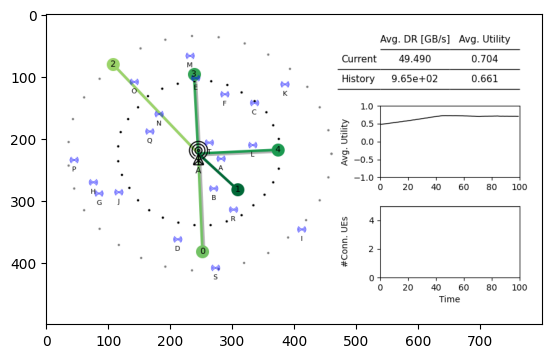

In [3]:
from IPython import display

# run the simulation for 20 time steps
done = False
obs, info = env.reset()

total_episode_reward = 0
total_reward_over_time = []  # List to store the reward at each time step

for _ in range(100):
    # here, use random dummy actions by sampling from the action space
    dummy_action = (0.75, 0.75)
    obs, reward, terminated, truncated, info = env.step(dummy_action)
    
    # accumulate total reward for the episode
    total_episode_reward += reward
    total_reward_over_time.append(total_episode_reward) 

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

plt.close()

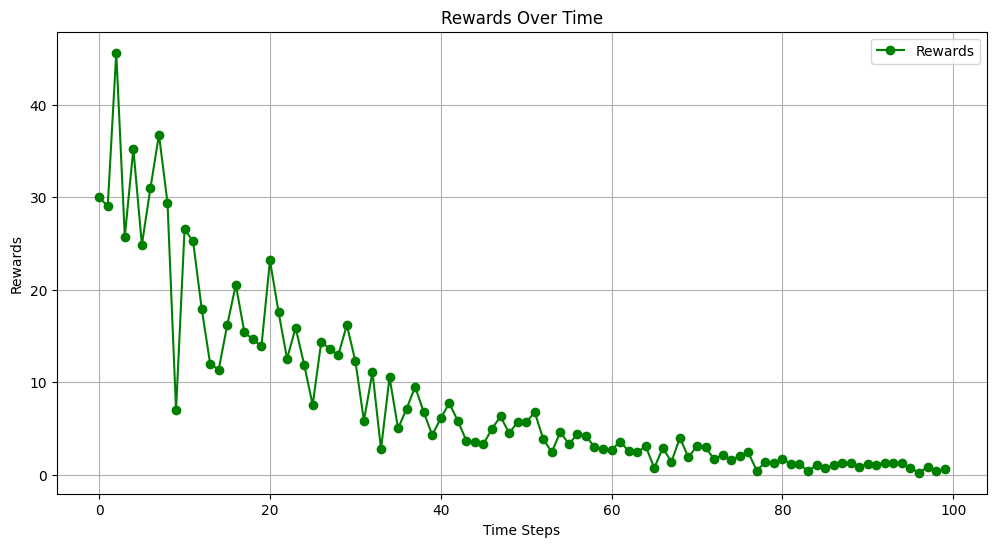

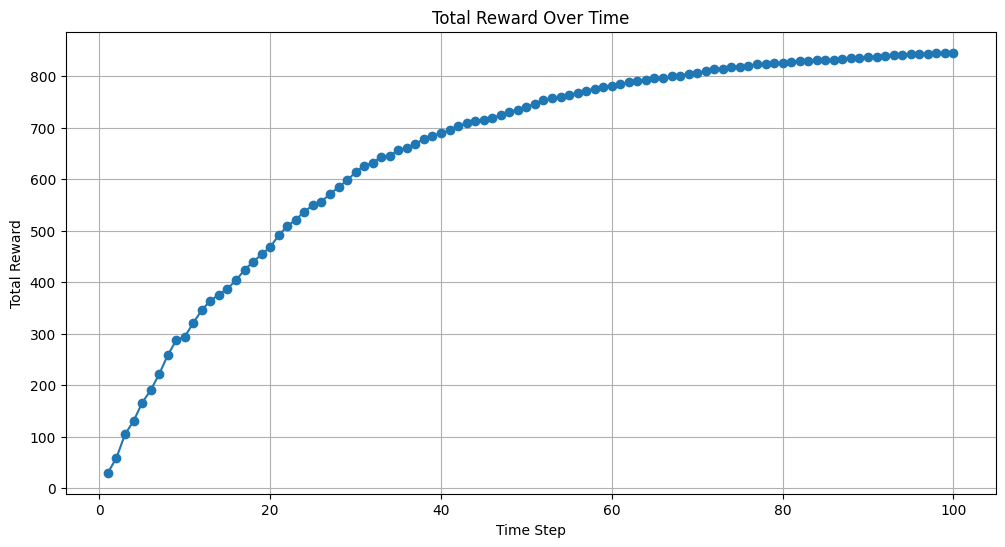

In [4]:
env.plot_rewards()

# Plot the reward over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(total_reward_over_time) + 1), total_reward_over_time, marker='o')
plt.title('Total Reward Over Time')
plt.xlabel('Time Step')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

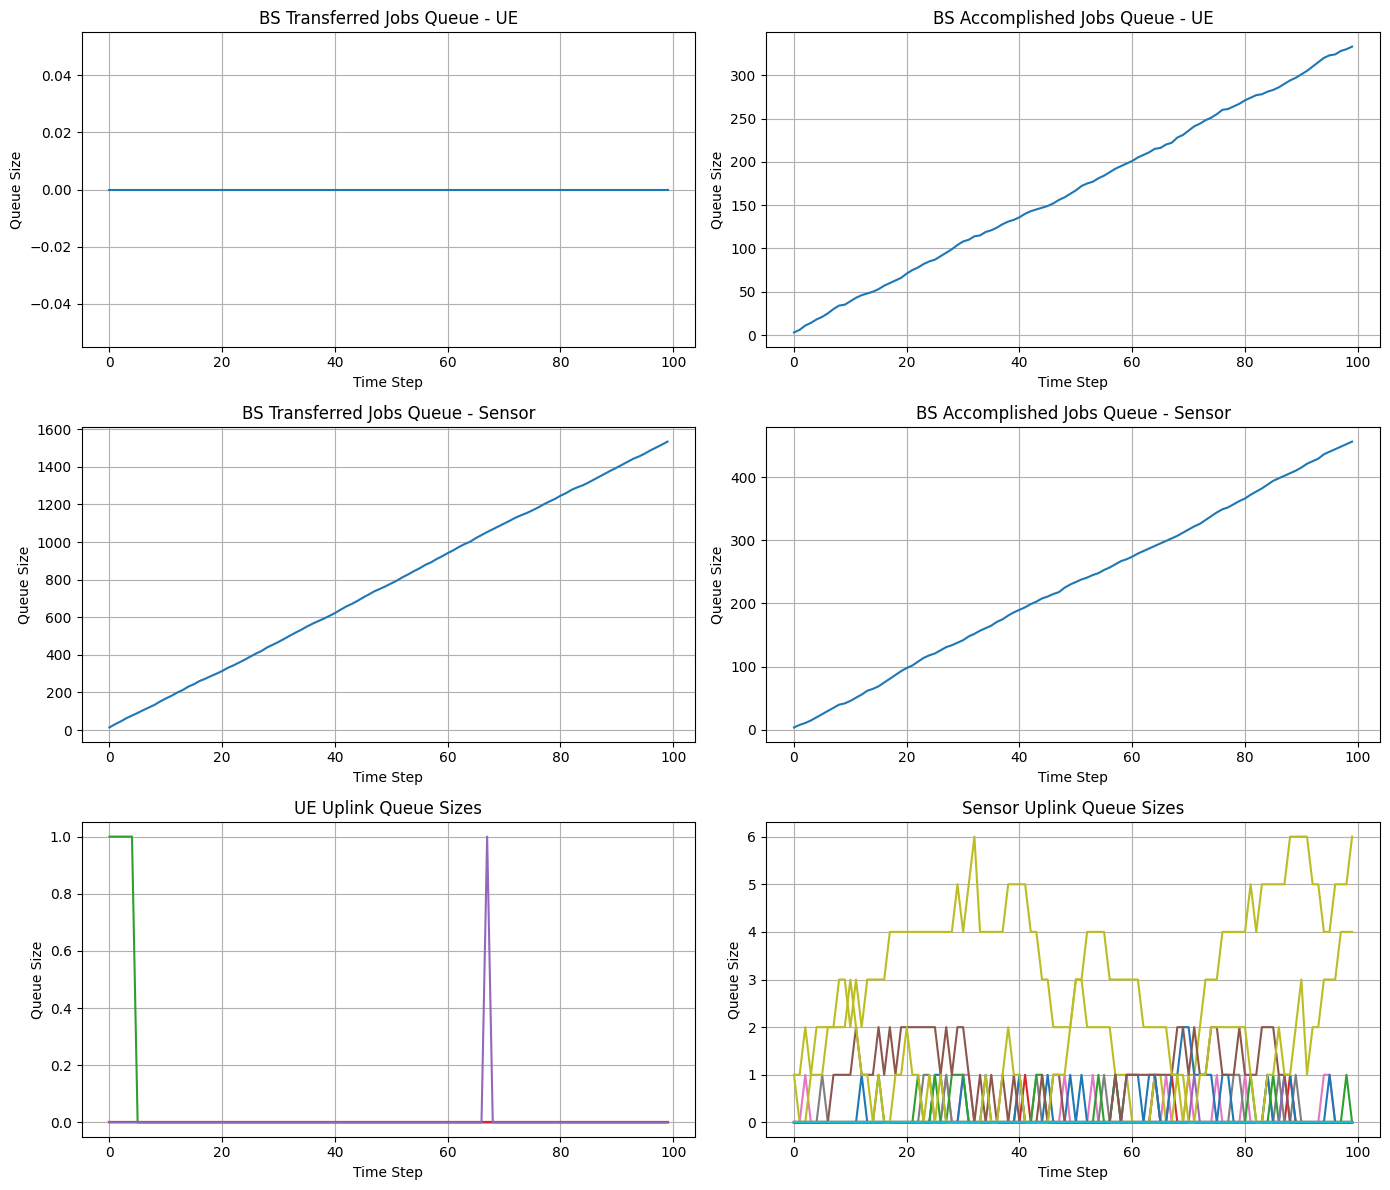

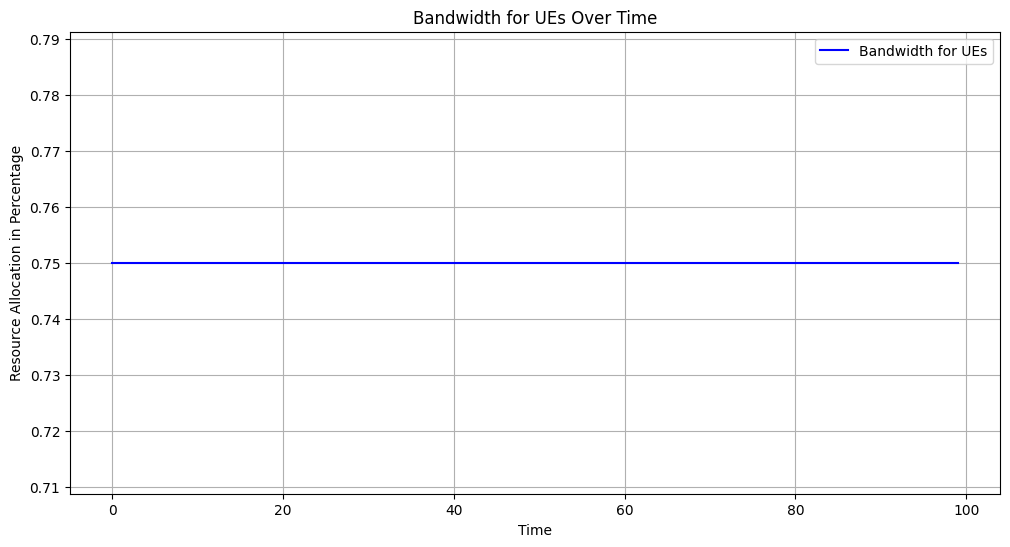

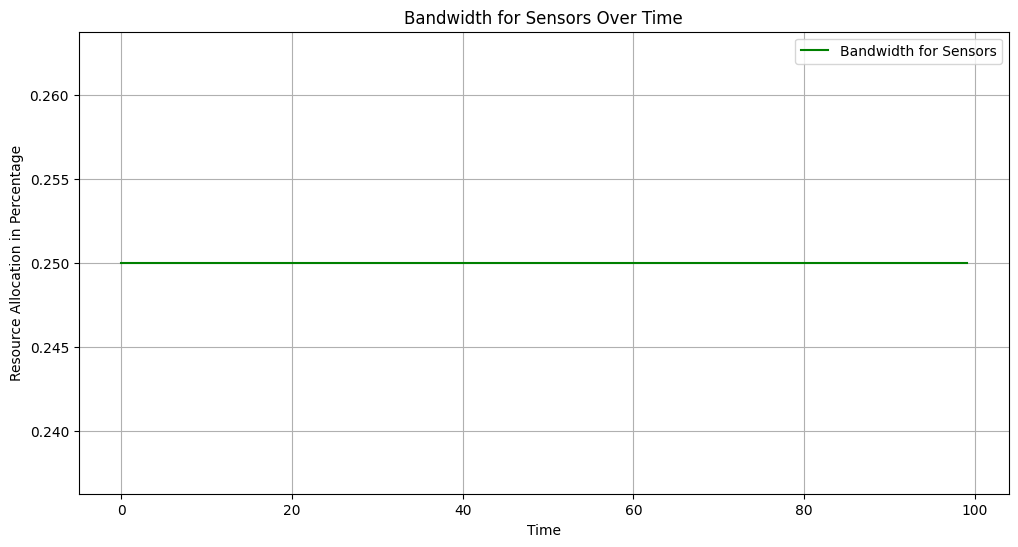

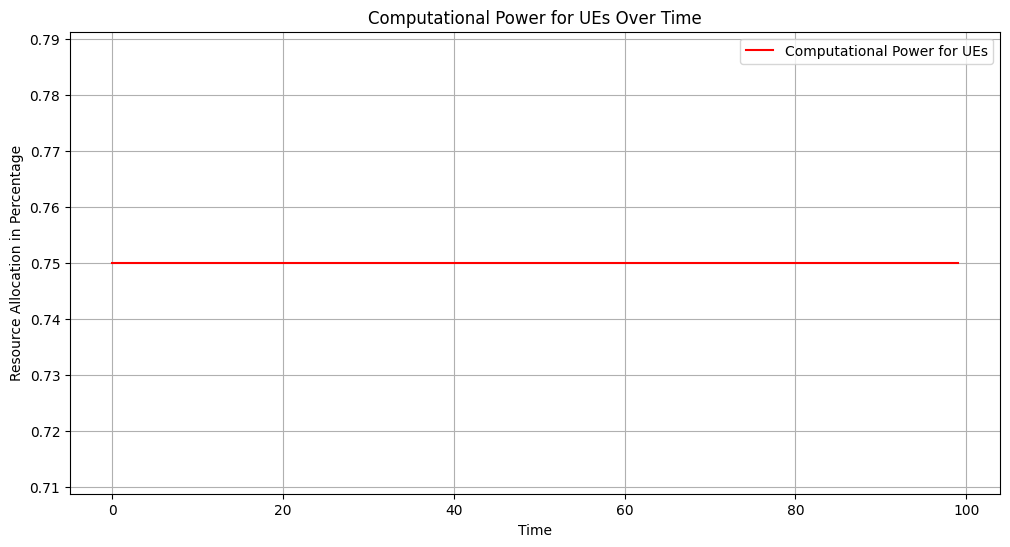

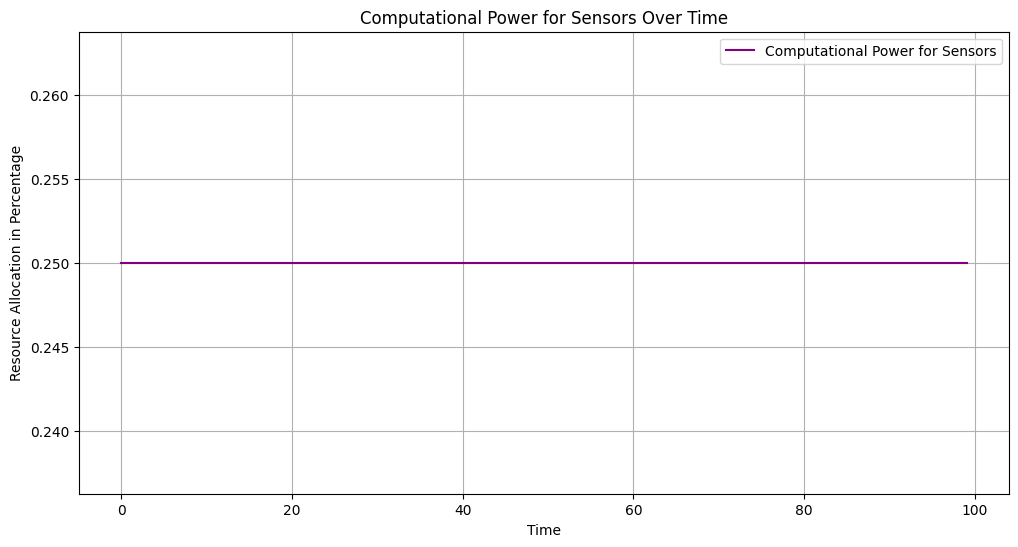

In [5]:
# Plot other environment metrics
env.plot_queue_sizes()
env.plot_resource_allocations()

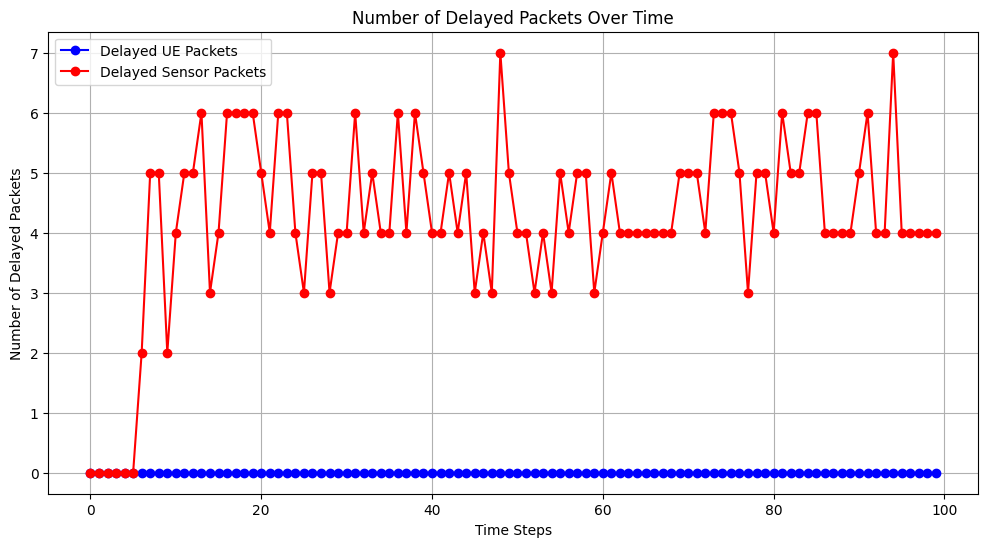

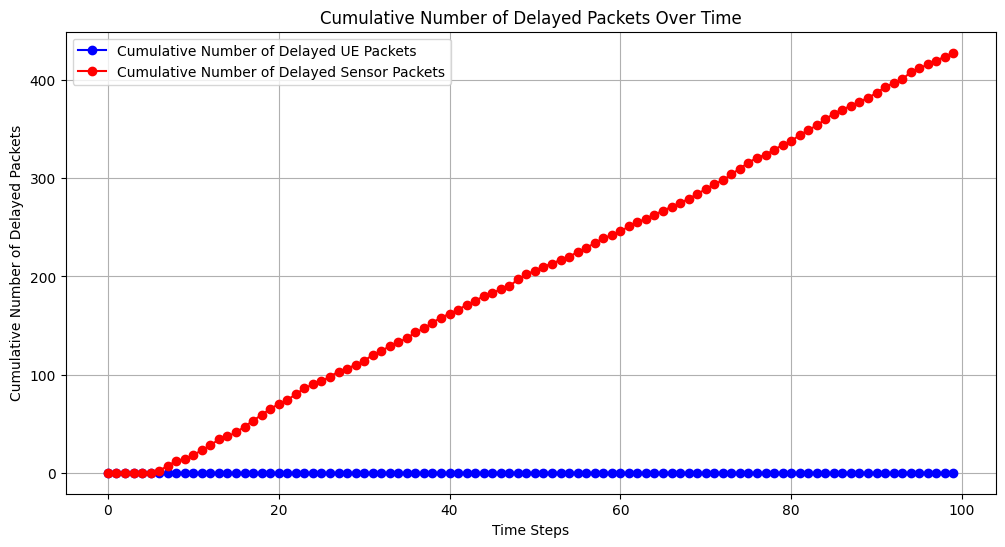

In [6]:
env.plot_delayed_packets()
env.plot_total_delayed_packets()

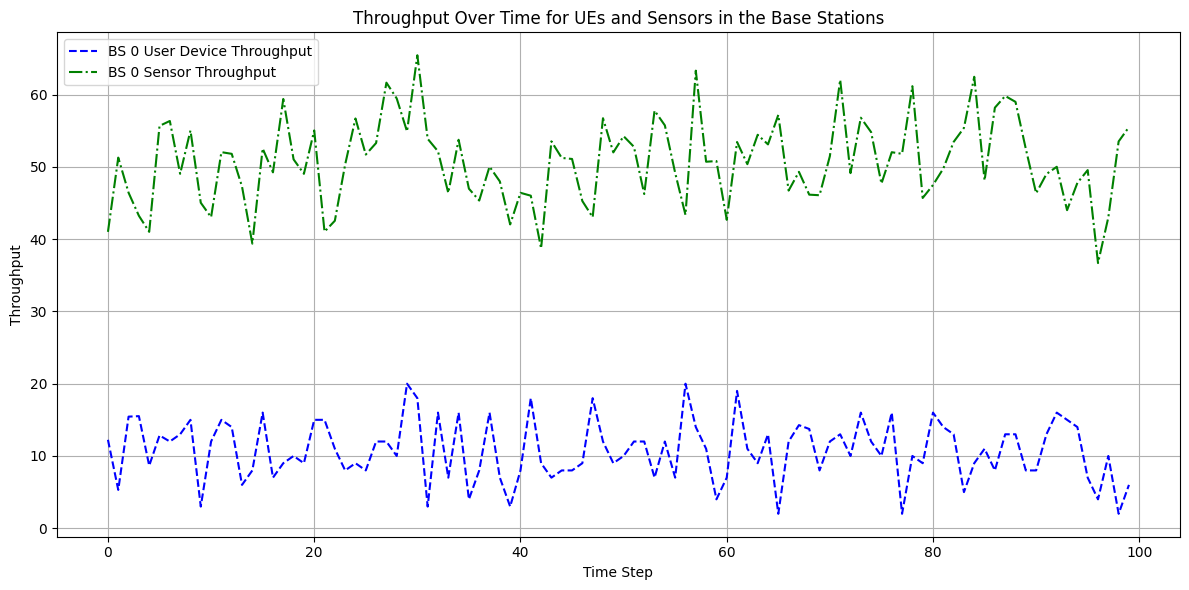

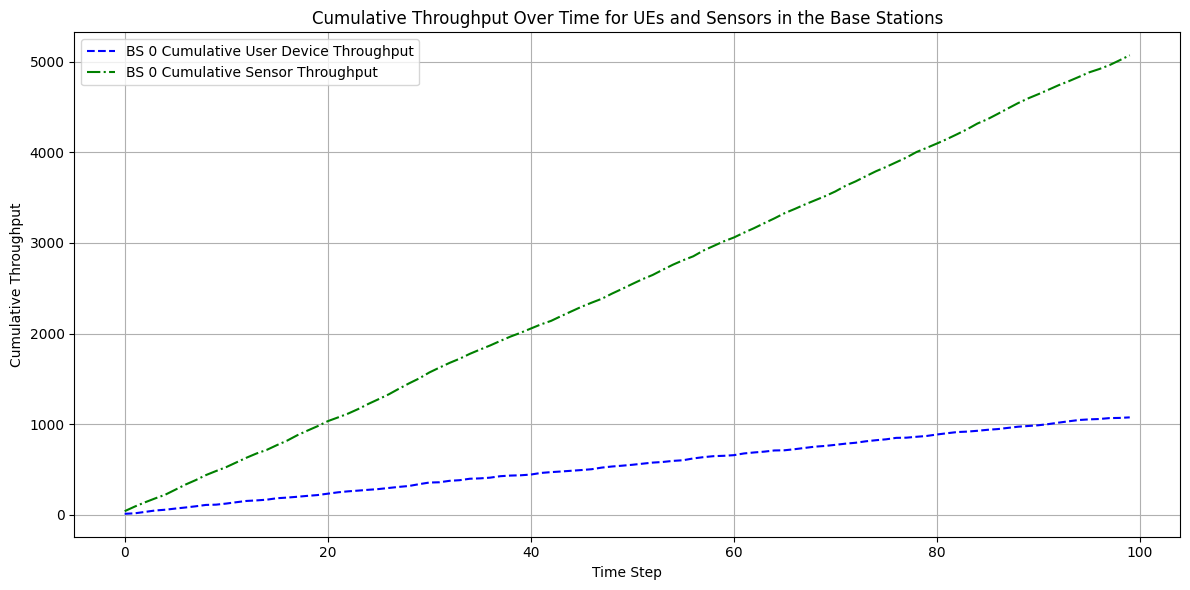

In [7]:
env.plot_throughput()
env.plot_cumulative_throughput()